In [1]:
import sys
sys.path.append('./../../')
sys.path.append('./..')
sys.path.append('./../../designer/script/')


from film import FreeFormFilm, BaseFilm, TwoMaterialFilm, EqOTFilm
from design import BaseDesign
from spectrum import BaseSpectrum, Spectrum
from optimizer.adam import AdamFreeFormOptimizer

from analyze_utils.make_design import make_edgefilter_design, make_triband_filter_design, make_reflection_design, get_minus_filter_spec

from utils.loss import calculate_RMS_f_spec
from analyze_utils.result_io import save, load
from analyze_utils.structure import plot_layer_thickness

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import pickle

In [20]:
# design = make_edgefilter_design()
# design = make_reflection_design(wls=np.linspace(695, 939, 500))
reps = 1

n_min = 1.5
n_max = 3

# adam optimizer parameters
alpha = 1e-2
batch_size = None
max_steps=1000
show = True

def exp(n_size, each_ot, target):
    np.random.seed()
    init_n = np.random.random(n_size) + 1.5
    init_film = EqOTFilm(init_n, each_ot * n_size, substrate=1.5)

    adam_optimizer = AdamFreeFormOptimizer(
        init_film, 
        target, 
        max_steps=max_steps, 
        alpha=alpha, # 0.01 for big OT films...
        record=True, 
        show=show, 
        n_min=n_min, # 1.5
        n_max=n_max, # 2.5
        wl_batch_size=batch_size # full 
    )

    adam_optimizer.optimize()
    return calculate_RMS_f_spec(init_film, target), init_film



#### Experiment: scan n_size AND each ot

In [34]:

# wl_min = 500
# wl_max = 1000 # 1 / wl_max - 1 / wl_min = 1 / 1000

# target = make_triband_filter_design().target_specs # 1 / wl_max - 1 / wl_min = 
wls = np.linspace(400., 700., 300)
target = [get_minus_filter_spec(wls)]
target_name = 'minus_filter'


n_size = 20
ot = 800
best_loss, best_film = exp(n_size, ot, target)


# save(f'./raw_result_sync/free_form_params_{target_name}_ot1e-1to1e3_nsize1to1e4.5_log_int_large_n_size', np.array(best_loss_arr_rep), np.array(best_film_arr_rep))

iter 0, loss 0.3777561502048952
iter 1, loss 0.3651628729807537
iter 2, loss 0.35226045786721777
iter 3, loss 0.3392687496504857
iter 4, loss 0.3266714247668908
iter 5, loss 0.31532296972924867
iter 6, loss 0.3056851730232738
iter 7, loss 0.29765213144503716
iter 8, loss 0.29089345402114575
iter 9, loss 0.2851634114374901
iter 10, loss 0.28033626919398424
iter 11, loss 0.27634484179421964
iter 12, loss 0.27314229052385175
iter 13, loss 0.27067929936670815
iter 14, loss 0.26887544137587566
iter 15, loss 0.267602718348822
iter 16, loss 0.2667031686445064
iter 17, loss 0.2660213039235255
iter 18, loss 0.2654305319079788
iter 19, loss 0.26484950022363285
iter 20, loss 0.26424338318205043
iter 21, loss 0.263609304599042
iter 22, loss 0.26295454755143793
iter 23, loss 0.26228012559765373
iter 24, loss 0.26157688454379385
iter 25, loss 0.26083078778086444
iter 26, loss 0.26002960364756333
iter 27, loss 0.2591670402777828
iter 28, loss 0.25824440412566174
iter 29, loss 0.25727078713193713
iter

0.21732609933361807


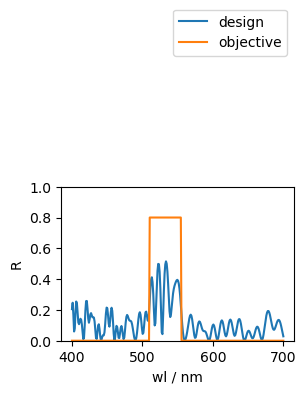

In [40]:
print(best_loss)
wls =np.linspace(400., 700., 300)
fig, ax = plt.subplots(1, 1)
ax.plot(wls, best_film.get_spec().get_R(), label='design')
ax.plot(wls, target[0].get_R(), label='objective')

ax.set_xlabel('wl / nm')
ax.set_ylabel('R')
ax.set_ylim(0, 1)
fig.set_size_inches(3, 2)
ax.legend(loc='center right', bbox_to_anchor=(1, 2))

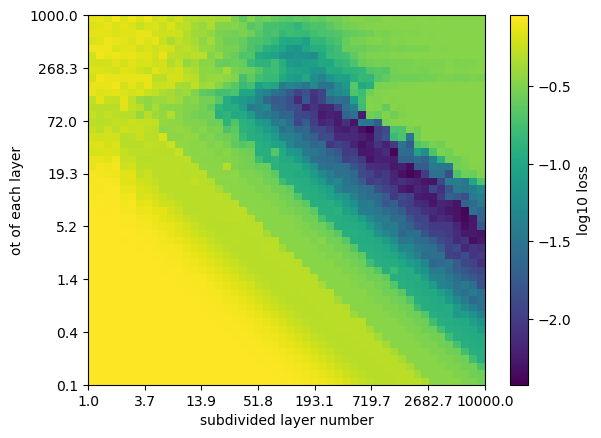

In [38]:

fig, ax = plt.subplots(1, 1)
s = ax.imshow(
    np.log10(best_loss_arr), 
    extent=[n_sizes[0], n_sizes[-1], each_ots[-1], each_ots[0]], 
    aspect='auto'
)
to_y = lambda x: (np.log10(x) - np.log10(each_ots[0])) * (-each_ots[0] + each_ots[-1]) / (-np.log10(each_ots[0]) + np.log10(each_ots[-1])) + each_ots[0]
to_x = lambda x: (np.log10(x) - np.log10(n_sizes[0])) * (-n_sizes[0] + n_sizes[-1] )/ (-np.log10(n_sizes[0]) + np.log10(n_sizes[-1])) + n_sizes[0]

if False:
    FT_lim = 1 / (1 / 400 - 1 / 400)
    ax.plot([to_x(n_sizes[0]), to_x(n_sizes[-1])], [to_y(FT_lim * 3/ 4), to_y(FT_lim * 3 / 4)], c='red', label='Fourier period limit')
    ax.plot([to_x(n_sizes[0]), to_x(n_sizes[-1])], [to_y(FT_lim * 5/ 4), to_y(FT_lim * 5 / 4)], c='red')
    ax.legend()
ax.invert_yaxis()
ax.set_ylabel('ot of each layer')
ax.set_xlabel('subdivided layer number')

interval = 6
make_ticks = lambda x: np.linspace(x[0], x[-1], x.shape[0] // interval)
make_tick_labels = lambda x, is_int=False: [f'{xi:.1f}' if not is_int else xi for xi in np.exp(np.linspace(np.log(x)[0], np.log(x)[-1], x.shape[0] // interval))]

ax.set_xticks(ticks=make_ticks(n_sizes), labels=make_tick_labels(n_sizes))
ax.set_yticks(ticks=make_ticks(each_ots), labels=make_tick_labels(each_ots))
# ax.set_ylim(5, None)
# ax.set_xlim(50, None)



cbar = fig.colorbar(s)
cbar.set_label('log10 loss')

fig.savefig('./results/design/Fourier/scan_ot_and_layernumber_log_int50.png', dpi=300)